In [4]:
# Tensorflow Check
import tensorflow as tf
from tensorflow.python.client import device_lib
import sys
print(f'Python     : {sys.version.split("|")[0]}')
print(f'Tensorflow : {tf.__version__}')
print(f'TF GPU     : {"True" if device_lib.list_local_devices()[1] else "False"}')

Python     : 3.10.11 
Tensorflow : 2.10.1
TF GPU     : True


In [11]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from tensorflow import keras

# 각종 변수 선언
csv_path = '../data/Regression_data.csv'
save_path = '../../../../../Git_Blog/assets/images/aib/GPTeachersDay/'
save_mode = 0

In [42]:
def load_dataset(csv_path, TRAIN_RATIO=0.8):
    
    global X, y, X_train, X_test, y_train, y_test, df
    
    # 데이터셋 로드
    df = pd.read_csv(csv_path)
    
    # 성별 원핫 인코딩
    df=pd.get_dummies(df,columns=['Sex'])
    
    # 껍질의 넓이 ( a * b * π)
    df['Area'] = 0.5 * df['Length'] * 0.5 * df['Diameter'] * np.pi
        
    # 껍질의 둘레 (근사) ( 2π*(0.5 * √(a^2 + b^2)))
    df['Perimeter'] = np.pi * np.sqrt(0.5 * ((df['Length'] ** 2) + (df['Diameter'] ** 2)))
    
    # 학습 데이터 분리
    X = df.drop('Rings', axis=1)
    y = df['Rings'].astype('float32')
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_RATIO, random_state = 83)
    
    return df, X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = load_dataset(csv_path)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3341, 12) (836, 12) (3341,) (836,)


In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,
            cmap="RdYlBu_r",
            annot=True,
            mask=mask,
            fmt='.2f',
            linewidths=.5,
            vmin = -1, vmax = 1,
            cbar_kws={"shrink": .5})

plt.show()

In [43]:
inputs  = keras.Input(shape=len(X_train.columns))
x       = keras.layers.Dense(8)(inputs)
x       = keras.layers.BatchNormalization()(x)
x       = keras.layers.Activation('relu')(x)
x       = keras.layers.Dense(8)(x)
x       = keras.layers.BatchNormalization()(x)
x       = keras.layers.Activation('relu')(x)
x       = keras.layers.Dense(8)(x)
x       = keras.layers.BatchNormalization()(x)
x       = keras.layers.Activation('relu')(x)
outputs = keras.layers.Dense(1)(x)
model   = keras.Model(inputs, outputs, name='Functional_Model')
print(model.summary())

Model: "Functional_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_32 (Dense)            (None, 8)                 104       
                                                                 
 batch_normalization_24 (Bat  (None, 8)                32        
 chNormalization)                                                
                                                                 
 activation_24 (Activation)  (None, 8)                 0         
                                                                 
 dense_33 (Dense)            (None, 8)                 72        
                                                                 
 batch_normalization_25 (Bat  (None, 8)                32        
 chNormalization)                                 

In [46]:
class EvalAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name="accuracy", **kwargs):
        super(EvalAccuracy, self).__init__(name=name, **kwargs)
        self.correct = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_predict, sample_weight=None):
        value = tf.abs((y_predict - y_true) / y_true)
        self.correct.assign(tf.reduce_mean(value))

    def result(self):
        return 1 - self.correct

    def reset_states(self):
        self.correct.assign(0.)

In [47]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss=keras.losses.MeanSquaredError(),
            metrics=[EvalAccuracy()])

history = model.fit(
  X_train, y_train,
  batch_size=16,
  validation_split = 0.2,
  verbose=1,
  epochs=20,
  )

Epoch 1/20
164/167 [============================>.] - ETA: 0s - loss: 112.3000 - accuracy: -0.0425

c:\Users\leeyeonjun85\.conda\envs\p310_1\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric EvalAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


167/167 [==============================] - 3s 15ms/step - loss: 112.1417 - accuracy: -0.0543 - val_loss: 109.6053 - val_accuracy: 0.0110
Epoch 2/20
167/167 [==============================] - 2s 14ms/step - loss: 109.0868 - accuracy: -0.0154 - val_loss: 103.6672 - val_accuracy: 0.0458
Epoch 3/20
167/167 [==============================] - 2s 14ms/step - loss: 106.0001 - accuracy: -0.0134 - val_loss: 102.8114 - val_accuracy: 0.0683
Epoch 4/20
167/167 [==============================] - 2s 14ms/step - loss: 103.1083 - accuracy: -0.0012 - val_loss: 100.9498 - val_accuracy: 0.0843
Epoch 5/20
167/167 [==============================] - 2s 14ms/step - loss: 100.4365 - accuracy: 0.0264 - val_loss: 98.2479 - val_accuracy: 0.0981
Epoch 6/20
167/167 [==============================] - 2s 13ms/step - loss: 97.9002 - accuracy: 0.0424 - val_loss: 95.3256 - val_accuracy: 0.1126
Epoch 7/20
167/167 [==============================] - 2s 13ms/step - loss: 95.2646 - accuracy: 0.0404 - val_loss: 92.1379 - val_

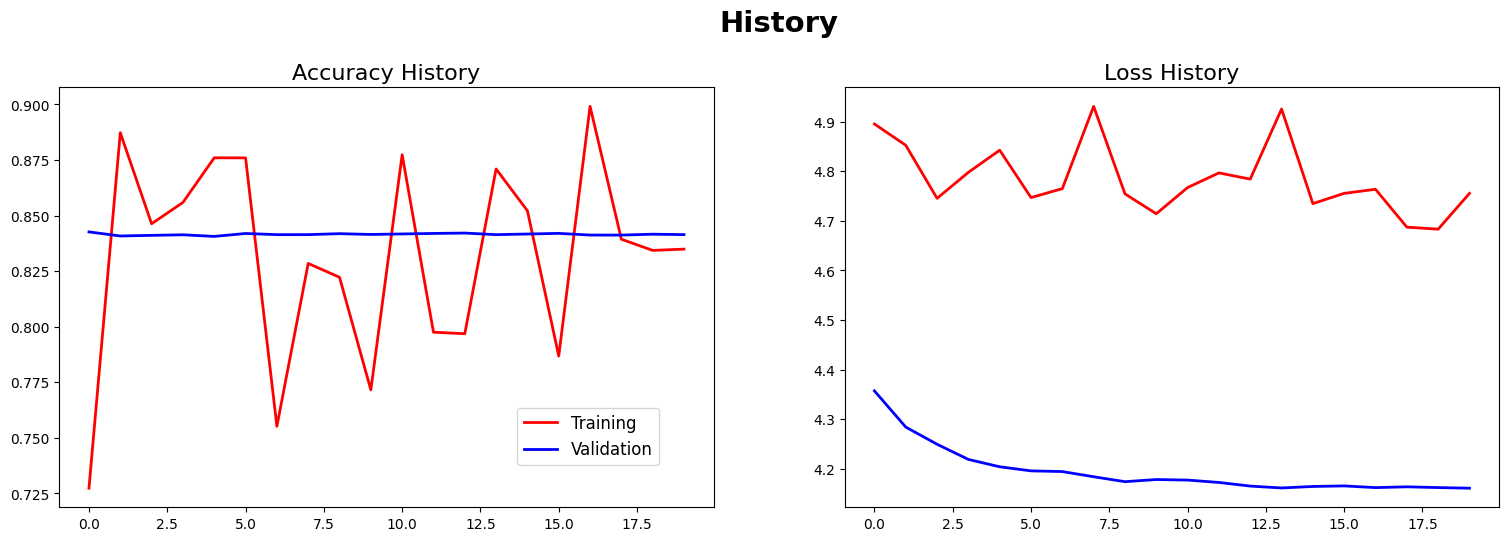

In [38]:
fig = plt.figure(figsize=(16, 6))
fig.suptitle('History', fontsize = 21, fontweight = 'bold', y = 0.98)

# Accuracy Plot
ax = plt.subplot(1, 2, 1)
plt.title(f'Accuracy History', fontsize = 16, y = 1)
plt.plot(history.history["accuracy"], color='r', linewidth=2, label="Training")
plt.plot(history.history["val_accuracy"], color='b', linewidth=2, label="Validation")

# Loss Plot
ax = plt.subplot(1, 2, 2)
plt.title(f'Loss History', fontsize = 16, y = 1)
plt.plot(history.history["loss"], color='r', linewidth=2, label="Training")
plt.plot(history.history["val_loss"], color='b', linewidth=2, label="Validation")

plt.legend(fontsize=12, loc=(-0.5, 0.1))
plt.subplots_adjust(right=0.95, left=0.05, top=0.85, bottom=0.15, wspace=0.2, hspace=0.2)
plt.show()